In [1]:
import ast, glob, hdbscan, cv2, time, math
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Ground truth
path = Path("dataset/ground_truth.csv")
data = np.genfromtxt(fname=path, delimiter=",", skip_header=1)

ground_truth_distance = data[:, 2].reshape(-1)
ground_truth_angle = data[:, 1].reshape(-1)

In [3]:
def open_raw_lidar_data(path):
    with open(path, "r") as f:
        data = f.readlines()[0]
        data = ast.literal_eval(data) # str to list
        data = np.array(data)

        return data


def conver_to_2txt(path):
    xdata = []
    ydata = []

    scan = open_raw_lidar_data(path)
    # angles = np.degrees(laser.get_angles()) + 90
    # x_lidar = scan * np.cos(np.radians(angles))
    # y_lidar = scan * np.sin(np.radians(angles))


    # create angle data list
    # (based on hokuyo.py, fun: get_angles)
    space = np.linspace(0, 1080, 1081) - 540        # 540: Step number of the front direction
    angle_manual = 2*np.pi*space/1440 + np.pi/2     # 1440: Angular resolution (number of partitions in 360 degrees), np.pi/2: 對齊車道方向
    x_lidar = scan * np.cos(angle_manual)
    y_lidar = scan * np.sin(angle_manual)

    for index, data in enumerate(scan):
        if int((int(x_lidar[index]))**2+(int(y_lidar[index]))**2)>4000000: # 判斷是否超過2m
            pass
        else:
            xdata.append(x_lidar[index])
            ydata.append(y_lidar[index])

    np.set_printoptions(threshold=10000)
    with open('lidar_pos_x.txt', 'w') as txtfile:
        for data in xdata:
            txtfile.writelines(str(int(data))+', ')

    with open('lidar_pos_y.txt', 'w') as txtfile:
        for data in ydata:
            txtfile.writelines(str(int(data))+', ')


def open_2_txt():
    with open("lidar_pos_x.txt", "r") as f:
        lidar_pos_x = f.read().split(', ')
        lidar_pos_x = [int(num) for num in lidar_pos_x if num != '']

    with open("lidar_pos_y.txt", "r") as f:
        lidar_pos_y = f.read().split(', ')
        lidar_pos_y = [int(num) for num in lidar_pos_y if num != '']

    lidar_data = np.stack([lidar_pos_x, lidar_pos_y], axis=1) # 將xy資料做合併

    # TODO　改為np.loadtxt
    # lidar_pos_x = np.loadtxt("lidar_pos_x.txt", dtype=np.int16, delimiter=",")
    return lidar_pos_x, lidar_pos_y, lidar_data


def plot_lidar_raw_fig(x_lidar, ylidar, save=False, filename=None):
    plt.cla() # 避免記憶體占用
    plt.xlim(-2000, 2000), plt.ylim(-2000, 2000)
    plt.xlabel("x (cm)"), plt.ylabel("y (cm)")
    plt.plot(x_lidar, ylidar, "ok", markersize=0.5)

    if save == True:
        plt.title(filename)
        plt.savefig(f"output_visualize/{filename}.jpg", dpi=300)
        return
    plt.show()



In [4]:
def get_function(x, y):
    """
    Calculate the slope and intercept of a line based on the given points,
    and generate a series of coordinates.
    If an error occurs during the calculation, return default values
    (slope and intercept are 0, and coordinates are 0).

    Parameters:
    - x, y (list): Lists containing the x and y coordinates of the points on the line.

    Returns:
    - x_0, y_0 (numpy array): Coordinates on the line.
    """
    try:
        # 計算斜率和截距
        a = (y[-1] - y[0]) / (x[-1] - x[0]) # TODO 確認斜率繪製取頭尾沒有問題
        b = y[0] - a * x[0]

        # 產生座標點
        y_0 = np.linspace(-1000, 1000, 4000) # TODO 有必要到4000那麼多嗎
        x_0 = (y_0 - b) / a
    except:
        a = 0
        b = 0
        y_0 = 0
        x_0 = 0
    return x_0, y_0 # 回傳線段中的各點座標


def get_degree_and_distance(x, y):
    """
    Calculate the slope and intercept of a line based on the given points,
    and the angle and distance of the line from the origin.

    Parameters:
    - x, y (list): Lists containing the x and y coordinates of the points on the line.

    Returns:
    - angle (float): Angle between the line and the horizontal direction (unit: degrees).
    - mid_dis (float): Distance between the midpoint of the line and the origin.
    """
    try:
        # 計算斜率和截距
        a = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - a * x[0]
        # y_0 = np.linspace(-1000, 1000, 4000)

        # 計算直線與水平方向的夾角
        mid_dis = (0 - b) / a
        angle = np.rad2deg(np.arctan2(y[1] - y[0], x[0] - x[1]))
    except:
        a = 0
        b = 0
        angle = 0
        mid_dis = 0
    return angle, mid_dis

In [5]:
def clustering(lidar_data, type="hdbscan", arrow=False, save=False, filename=None):
    
    # Choose the clustering method
    if type == "dbscan":
        clustering = DBSCAN(algorithm='auto', eps=300, leaf_size=30, metric='euclidean',
            metric_params=None, min_samples=30, n_jobs=-1, p=None)
    elif type == "hdbscan":
        clustering = hdbscan.HDBSCAN(min_cluster_size=70,  core_dist_n_jobs=-1)
    else:
        raise ValueError("Unknown clustering type")

    # 計時
    start = time.perf_counter()
    clustering = clustering.fit(lidar_data)
    stop = time.perf_counter()
    spend_time = stop - start

    label = clustering.labels_

    # clustering.minimum_spanning_tree_.plot()

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.clear()
    ax.scatter(lidar_data[:,0], lidar_data[:,1], c=label, s=1)
    ax.set_xlim(left=-2000, right=2000)
    ax.set_ylim(bottom=-2000, top=2000)
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    # ax.set_title('LiDAR Scanning')

    # Draw center line
    ax.vlines(x=0, ymin=-1000, ymax=1000, color='k', linewidth=2, linestyle='--')
    ax.hlines(y=0, xmin=-500, xmax=500, color='gray', linewidth=2, linestyle='--')

    if arrow:
        x_data_array = []
        y_data_array = []
        x_0list = []
        y_0list = []
        x_mean_list= []
        label_array = []
        
        # TODO　應該可以簡化成不用雙迴圈
        # clustering 標籤類別
        for j in range(clustering.labels_.max() + 1): # TODO 修改成.max(), 避免空數值
            x_data_array = []
            y_data_array = []

            # 所有資料進行比對
            for i in range(len(lidar_data)):
                if clustering.labels_[i] == j:
                    xdata = lidar_data[:,0][i]
                    ydata = lidar_data[:,1][i]
                    label = clustering.labels_[i]

                    x_data_array.append(xdata)
                    y_data_array.append(ydata)
                    label_array.append(label)
        
            x_mean = np.mean(x_data_array)
            x_mean_list.append(x_mean)

        if len(x_mean_list) >= 2:
            try:
                # 求出大於 0 中最靠近 0 的數的索引
                x_mean_list = np.array(x_mean_list)
                gt_indices = np.where(x_mean_list > 0)[0]
                gt_min_index = np.argmin(np.abs(x_mean_list[gt_indices]))
                actual_gt_min_index = gt_indices[gt_min_index]

                # 求出小於 0 中最靠近 0 的數的索引
                lt_indices = np.where(x_mean_list < 0)[0]
                lt_min_index = np.argmin(np.abs(x_mean_list[lt_indices]))
                actual_lt_min_index = lt_indices[lt_min_index]
                actual_min_index = [actual_gt_min_index, actual_lt_min_index]
                # print(f"min_distanse: [{x_mean_list[actual_lt_min_index]:.3f}, {x_mean_list[actual_gt_min_index]:.3f}]")

            # 避免全部都在同一側無法選取，提早結束
            except Exception as e:
                # print("Error:",e)
                return float("nan"), float("nan"), spend_time

            # 跑兩次迴歸找最近的兩區域
            for j in actual_min_index:
                x_data_array = []
                y_data_array = []

                for i in range(len(lidar_data)):
                    if clustering.labels_[i] == j:
                        xdata = lidar_data[:,0][i]
                        ydata = lidar_data[:,1][i]
                        label = clustering.labels_[i]

                        x_data_array.append(xdata)
                        y_data_array.append(ydata)


                model = LinearRegression()
                x_0 = np.expand_dims(x_data_array, axis=1)
                y_0 = np.expand_dims(y_data_array, axis=1)
                model.fit(y_0, x_0)
                x_predict_0 = model.predict(y_0)

                x_0, y_0 = get_function(x_predict_0, y_0)
                plt.plot(x_0, y_0, c = 'red')
                x_0list.append(x_0)
                y_0list.append(y_0)


            # CREATE reference line
            x_c = (x_0list[0] + x_0list[1]) / 2
            y_c = (y_0list[0] + y_0list[1]) / 2
            lidar_angle, mid_dis = get_degree_and_distance(x_c, y_c)
            lidar_angle = lidar_angle - 90 # 先轉為與y軸的夾角
            plt.arrow(x_c[0], y_c[0], (x_c[-1]-x_c[0]), (y_c[-1]-y_c[0]), head_length=100, head_width=100, color="blue")
            # print(f'LiDAR output: angle = {(lidar_angle):.3f}, dis = {mid_dis:.3f}')
            
            # 除以最大值得到誤差比例
            # lidar_angle_error = lidar_angle / 90
            # mid_dis_error = mid_dis / 2000
            # print(f"Error       : angle = {lidar_angle_error:.3f}, dis = {mid_dis_error:.3f}")
            

    # 將群集數量顯示於圖上
    # plt.text(x=-1750, y=-1750, s=f"number of clusters = {clustering.labels_.max() + 1}")

    if save == True:
        ax.set_title(filename)
        if type == "dbscan":
            plt.savefig(f"output_dbscan/{filename}.jpg", dpi=300)
        elif type == "hdbscan":
            plt.savefig(f"output_hdbscan/{filename}.jpg", dpi=300)
        plt.close(fig)

    else:
        # plt.show()
        plt.close(fig)
        # plt.savefig(f"ppt_fig.jpg", dpi=300)

    # 避免無法分群沒有回傳值
    try:
        lidar_angle= lidar_angle
        mid_dis = mid_dis

    except Exception  as e:
        lidar_angle= float("nan")
        mid_dis = float("nan")
        # print("Error:",e)

    return lidar_angle, mid_dis, spend_time


# # 單張測試
path = Path("dataset/135.txt")
conver_to_2txt(path)
lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()

# lidar_angle, mid_dis, spend_time = clustering(lidar_data, type="dbscan",  arrow=True)
lidar_angle, mid_dis, spend_time = clustering(lidar_data, type="hdbscan", arrow=True)
# print("lidar_angle", lidar_angle, "mid_dis", mid_dis, "spend_time", spend_time)

In [6]:
def run_all_plt(type="raw", arrow=False, save=False):
    all_pic_path = Path("./dataset").glob("*.txt")
    
    # 因glob出來的結果不會做排序，造成跟csv中檔案順序不同，應急先暴力解決
    num = []
    for i in all_pic_path:
        num.append(i.stem)
    
    num = sorted(num, key=lambda x:int(x))
    output_dis = []
    output_angle = []
    clustering_time_list = []

    if type == "raw":        
        if not Path("output_visualize").exists():
            Path("output_visualize").mkdir()

        number_of_path = 0
        for path in num:
            conver_to_2txt(path="./dataset/"+ str(path)+'.txt')
            lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
            plot_lidar_raw_fig(lidar_pos_x, lidar_pos_y, save=True, filename= str(path))
            number_of_path += 1
        print(f"saved {number_of_path} files.")


    elif type == "dbscan":
        if not Path("output_dbscan").exists():
            Path("output_dbscan").mkdir()

        number_of_path = 0
        for path in num:
            # print("filename:", path.stem)
            conver_to_2txt(path="./dataset/"+ str(path)+'.txt')
            lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
            lidar_angle, mid_dis, spend_time = clustering(lidar_data, type="dbscan", arrow=arrow, save=save, filename=str(path))
            output_dis.append(mid_dis)
            output_angle.append(lidar_angle)
            clustering_time_list.append(spend_time)
            number_of_path += 1

        # print(f"saved {number_of_path} files.")
        return np.array(output_dis), np.array(output_angle), np.sum(np.array(clustering_time_list))

    
    elif type == "hdbscan":
        if not Path("output_hdbscan").exists():
            Path("output_hdbscan").mkdir()

        
        number_of_path = 0
        for path in num:
            # print("filename:", path)
            # print("filename:", path.stem)
            conver_to_2txt(path="./dataset/"+ str(path)+'.txt')
            lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
            lidar_angle, mid_dis, spend_time = clustering(lidar_data, type="hdbscan", arrow=arrow, save=save, filename=str(path))
            output_dis.append(mid_dis)
            output_angle.append(lidar_angle)
            clustering_time_list.append(spend_time)
            number_of_path += 1

        # print(f"saved {number_of_path} files.")
        return np.array(output_dis), np.array(output_angle), np.sum(np.array(clustering_time_list))

    else:
        print("no match type.")

In [7]:
# Visulize totle data.
# run_all_plt(type="raw")

DBSCAN： 
157, 161 無法分群

HDBSCAN：
* 99, 108 142 144 151 152 156 157 160結果奇怪
* 136 奇怪 好像右邊都是雜訊
* 154 無法分

DBSCAN time (clustering)     : 0.1953806260000035 (s)
DBSCAN time (including plot) : 1.73765396 (s)
DBSCAN (RMSE) : distance = 313.64409429322427, angle = 13.195791117568527
--------------------------------------------------
HDBSCAN time (clustering)     : 0.4816121630000021 (s)
HDBSCAN time (including plot) : 1.99552754 (s)
HDBSCAN (RMSE) : distance = 143.6749817681513, angle = 9.919573159133373
--------------------------------------------------


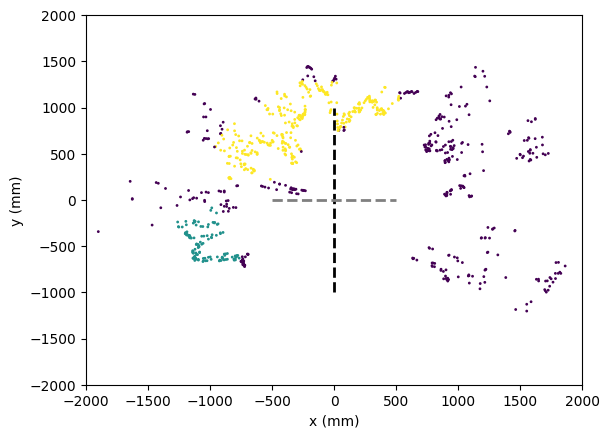

In [8]:
# ============================ DBSCAN ==============================
start = time.perf_counter()
output_dis, output_angle, pure_clustering_time = run_all_plt(type="dbscan", arrow=True, save=False)
stop = time.perf_counter()
print(f"DBSCAN time (clustering)     : {pure_clustering_time} (s)")
print(f"DBSCAN time (including plot) : {stop - start:.8f} (s)")

# Calculate the RMSE error
rmse_dis = np.sqrt(np.nanmean((ground_truth_distance - output_dis) ** 2)) # 排除nan值以免error
rmse_angle = np.sqrt(np.nanmean((ground_truth_angle - output_angle) ** 2)) 
print(f"DBSCAN (RMSE) : distance = {rmse_dis}, angle = {rmse_angle}")
print("-"*50)

# ============================ HDBSCAN ==============================
start = time.perf_counter()
output_dis, output_angle, pure_clustering_time = run_all_plt(type="hdbscan", arrow=True, save=False)
stop = time.perf_counter()
print(f"HDBSCAN time (clustering)     : {pure_clustering_time} (s)")
print(f"HDBSCAN time (including plot) : {stop - start:.8f} (s)")

# Calculate the RMSE error
rmse_dis = np.sqrt(np.nanmean((ground_truth_distance - output_dis) ** 2))
rmse_angle = np.sqrt(np.nanmean((ground_truth_angle - output_angle) ** 2))
print(f"HDBSCAN (RMSE) : distance = {rmse_dis}, angle = {rmse_angle}")
print("-"*50)

In [9]:
# calculate the FPS
# ============================ DBSCAN ==============================
all_pic_path = Path("./dataset").glob("*.txt")
num = []
for i in all_pic_path:
    num.append(i.stem)
num = sorted(num, key=lambda x:int(x))

dbscan_time_list = []

num_times = 1000
start = time.perf_counter()
for i in range(num_times):
    conver_to_2txt(Path("./dataset/115.txt"))
    lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
    _, _, spend_time = clustering(lidar_data, type="dbscan", arrow=True, save=False)
    dbscan_time_list.append(spend_time)
    if i % (num_times/10) == 0:
        print(f"{i / num_times:.1%}", end="\r")

stop = time.perf_counter()
spend_time = stop - start
    

dbscan_time_list = np.array(dbscan_time_list)
print(f"Time: {np.sum(dbscan_time_list)} s")
print(f"Mean: {np.mean(dbscan_time_list)}")
print(f"Sandard: {np.std(dbscan_time_list)}")
print(f"Varience: {np.var(dbscan_time_list):.10f}")
print("")

fps = num_times / spend_time
print(f"FPS: {fps}")
print("----------------------------------------------------------------")

# ============================ HDBSCAN ==============================
hdbscan_time_list = []

num_times = 1000
start = time.perf_counter()
for i in range(num_times):
    conver_to_2txt(Path("./dataset/115.txt"))
    lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()
    _, _, spend_time = clustering(lidar_data, type="hdbscan", arrow=True, save=False)
    hdbscan_time_list.append(spend_time)
    if i % (num_times/10) == 0:
        print(f"{i / num_times:.1%}", end="\r")
stop = time.perf_counter()
spend_time = stop - start

hdbscan_time_list = np.array(hdbscan_time_list)
print(f"Time: {np.sum(hdbscan_time_list)} s")
print(f"Mean: {np.mean(hdbscan_time_list)}")
print(f"Sandard: {np.std(hdbscan_time_list)}")
print(f"Varience: {np.var(hdbscan_time_list):.10f}")
print("")

fps = num_times / spend_time
print(f"FPS: {fps}")

Time: 2.5461450969999913 s
Mean: 0.0025461450969999915
Sandard: 0.0008814489747169779
Varience: 0.0000007770

FPS: 38.60363826841006
----------------------------------------------------------------
Time: 6.616204743000118 s
Mean: 0.006616204743000118
Sandard: 0.0008212993833713037
Varience: 0.0000006745

FPS: 34.8245314756455


<AxesSubplot: ylabel='$\\lambda$ value'>

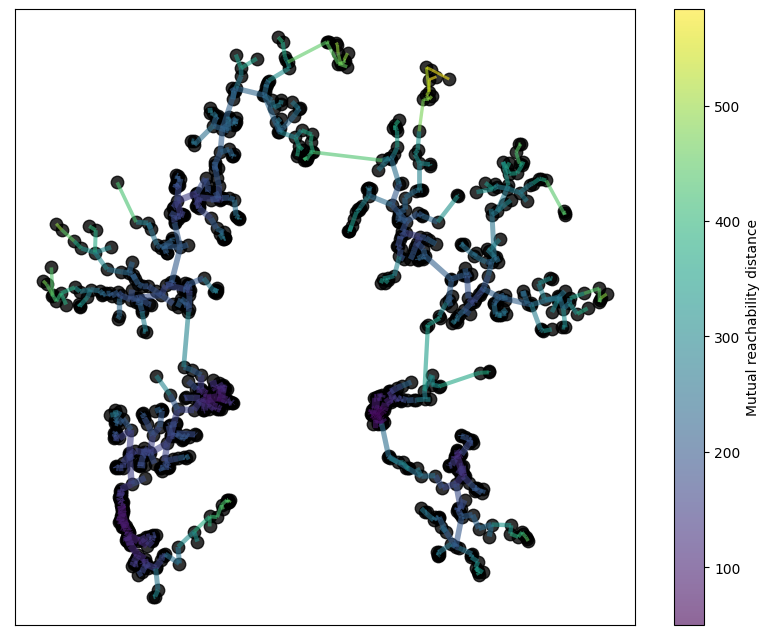

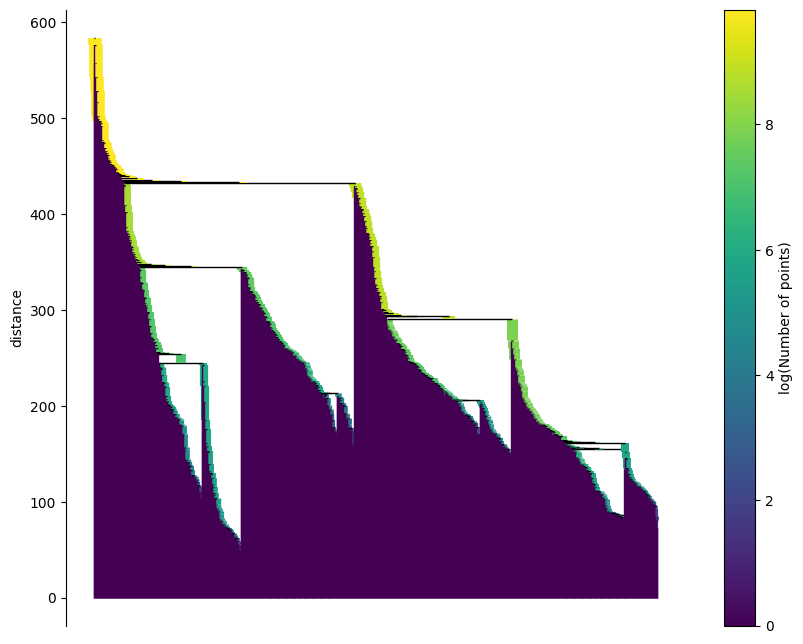

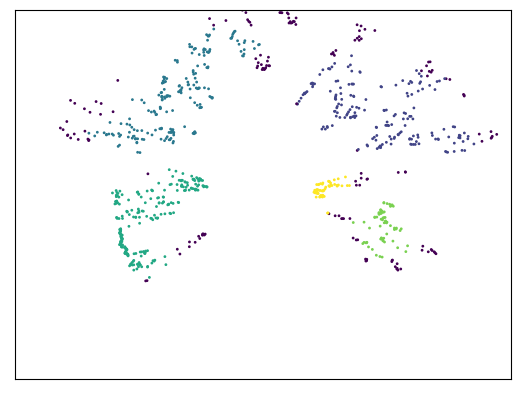

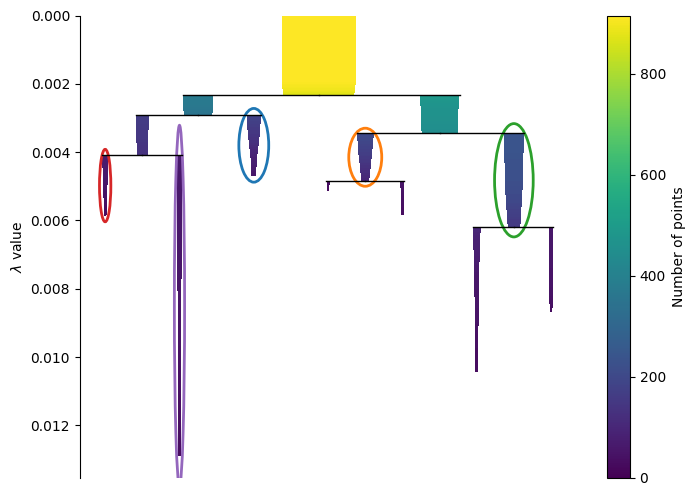

In [11]:
#============= Plot hierarchy diagram ====================

path = Path("dataset/109.txt")
conver_to_2txt(path)
lidar_pos_x, lidar_pos_y, lidar_data = open_2_txt()

clustering = hdbscan.HDBSCAN(min_cluster_size=30,  core_dist_n_jobs=-1, gen_min_span_tree=True) 
clustering = clustering.fit(lidar_data)

plt.figure(figsize=(10,8))
clustering.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)
# plt.savefig("minimum spanning tree.png", dpi=300)

plt.figure(figsize=(10,8))
clustering.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
# plt.savefig("cluster hierarchy.png", dpi=300)


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.clear()
ax.scatter(lidar_data[:,0], lidar_data[:,1], c=clustering.labels_, s=1)
ax.set_xlim(left=-2000, right=2000)
ax.set_ylim(bottom=-2000, top=2000)
ax.set_xticks([]), ax.set_yticks([])
# plt.savefig("cluster.png", dpi=300)

import seaborn as sns
plt.figure(figsize=(8,6))
clustering.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.savefig("condensed_tree.png", dpi=300)